In [1]:
from collections import Counter

import graph_tool.all as gt
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

from partial_rankings.dataset import read_matchlist, gt_from_match_list
from partial_rankings.model import partial_rankings
from partial_rankings.preprocessing import get_N, get_M, get_edges

# LaTeX preamble
matplotlib.rcParams.update({"text.usetex": True})
matplotlib.rcParams.update({"text.latex.preamble": r"", "font.serif": "Times"})
matplotlib.rcParams.update({"font.family": "serif"})

In [2]:
# Load match list
matchlist = read_matchlist("data/raw/match_lists/wolf.txt")

# Extract features from matchlist
N = get_N(matchlist)  # Number of players
M = get_M(matchlist)  # Number of matches
e_out, e_in = get_edges(matchlist)  # Out and in edges

# Fit model
model_fit = partial_rankings(N, M, e_out, e_in, full_trace=True)

Runing prior w/out constant terms


Initial DL: 1056.1296139214437
Initial Ranks: 15
Tolerance: 1e-06
Converged in 15 iterations
Partial Rankings: 10
Initial DL: 1056.1296139214437
Min DL: 1049.5129726611476
Bradley-Terry DL: 1025.5222923365006
Log posterior-odds ratio: -23.990680324646974
Compression Ratio (CR): 0.9937350101984848


Note that, in this case, the log posteror-odds ratio is negative, so the Bradley-Terry model is to be preferred over the partial rankings one.

Let's plot the results.

In [3]:
# Extract Description Length (DL) list
dl_list = [el['DL'] for el in model_fit]

# Identify argmin
min_idx = np.argmin(dl_list)

# Extract results at min DL
results = model_fit[min_idx]

# Extract BT results
bt_results = model_fit[0]

In [4]:
# Count the number of times each match occurs
match_count = Counter([tuple(match) for match in matchlist])
# Generate a list of matches with weights
weighted_matchlist = np.array([[match[0], match[1], count] for match, count in match_count.items()])

# Generate a gt.Graph object from the weighted matchlist
g = gt_from_match_list(weighted_matchlist)

In [5]:
# Extract clusters from results
clusters = results['Clusters']

# Extract player strengths from results
sigmas = results['Strengths']

# Extract BT strengths
bt_sigmas = bt_results['Strengths']

# Create a dictionary mapping player indices to cluster strengths
player_strengths = {}
for cluster_label, cluster_set in clusters.items():
    for player in cluster_set:
        player_strengths[player] = sigmas[cluster_label]

In [6]:
# Create a vertex property map for the player strengths
rating = g.new_vertex_property("double")

# Create a vertex property map for the player BT strengths
bt_rating = g.new_vertex_property("double")

# Create a vertex property map for the nodes positions
pos_bt = g.new_vertex_property("vector<double>")
pos_pr = g.new_vertex_property("vector<double>")

# Create a vertex property map for the cluster labels
cluster_labels = g.new_vertex_property("int")

# Create a vertex property map for the BT labels
bt_labels = g.new_vertex_property("int")

# Assign the player strengths to the vertex property map
for i, v in enumerate(g.vertices()):
    rating[v] = player_strengths[g.vp.id[v]]
    bt_rating[v] = bt_sigmas[g.vp.id[v]]
    pos_pr[v] = [-i, -np.log(rating[v])]  # Position nodes based on PR strengths
    pos_bt[v] = [-i, -np.log(bt_rating[v])]  # Position nodes based on BT strengths
    for j, cluster in enumerate(clusters):
        if g.vp.id[v] in clusters[cluster]:
            cluster_labels[v] = int(j)
            bt_labels[v] = int(i)

# Assign the vertex property maps to the graph
g.vp.rating = rating
g.vp.bt_rating = bt_rating
g.vp.pos_bt = pos_bt
g.vp.pos_pr = pos_pr
g.vp.cluster_labels = cluster_labels
g.vp.bt_labels = bt_labels

In [7]:
"""Redefine node positions for better visualization"""

# Define cluser_rating: v dictionary
cluster_label_v = {}
for v in g.vertices():
    cluster_label = g.vp.cluster_labels[v]
    if cluster_label not in cluster_label_v:
        cluster_label_v[cluster_label] = []
    cluster_label_v[cluster_label].append(v)

scaling_factor = 1.0

for cluster_label, vertices in cluster_label_v.items():
    if len(vertices) == 1:
        # Set x position to 0
        for v in vertices:
            g.vp.pos_bt[v] = [0, g.vp.pos_bt[v][1] * scaling_factor]
            g.vp.pos_pr[v] = [0, g.vp.pos_pr[v][1] * scaling_factor]
    elif len(vertices) == 2:
        # Evenly space nodes around in [-a, a] interval
        a = 2
        x_coords = np.linspace(-a, a, len(vertices))
        for i, v in enumerate(vertices):
            g.vp.pos_bt[v] = [x_coords[i], g.vp.pos_bt[v][1] * scaling_factor]
            g.vp.pos_pr[v] = [x_coords[i], g.vp.pos_pr[v][1] * scaling_factor]
    else:
        # Evenly space nodes around in [-a, a] interval
        a = 6
        x_coords = np.linspace(-a, a, len(vertices))
        for i, v in enumerate(vertices):
            g.vp.pos_bt[v] = [x_coords[i], g.vp.pos_bt[v][1] * scaling_factor]
            g.vp.pos_pr[v] = [x_coords[i], g.vp.pos_pr[v][1] * scaling_factor]

In [8]:
# Use a sequential colormap for vertex fill color
vertex_fill_color = g.new_vertex_property("double")
for v in g.vertices():
    vertex_fill_color[v] = np.log(g.vp.rating[v])

# Set colormap range
vmin = -11
vmax = 9

# Get list of ratings for each node in g
ratings_bt = [g.vp.bt_rating[v] for v in g.vertices()]
ratings_pr = [g.vp.rating[v] for v in g.vertices()]
# Sort ratings
ratings_bt.sort()
ratings_pr.sort()
# Create a dictionary mapping each unique rating to an index
rating_bt_to_index = {rating: i for i, rating in enumerate(np.sort(list(set(ratings_bt))))}
rating_pr_to_index = {rating: i for i, rating in enumerate(np.sort(list(set(ratings_pr))))}
# Create a new vertex property map mapping each rating to its index
g.vp.vranking_bt = g.new_vertex_property("int")
g.vp.vranking_pr = g.new_vertex_property("int")
for v in g.vertices():
    g.vp.vranking_bt[v] = rating_bt_to_index[g.vp.bt_rating[v]]
    g.vp.vranking_pr[v] = rating_pr_to_index[g.vp.rating[v]]

# Draw the graph with the colormap range set between -100 and 100
output = {
    "bt": "data/processed/bt_network.png",
    "pr": "data/processed/pr_network.png"
}
vpos = {
    "bt": g.vp.pos_bt,
    "pr": g.vp.pos_pr
}
vtext = {
    "bt": g.vp.vranking_bt,
    "pr": g.vp.vranking_pr
}

for key in ["bt", "pr"]:
    gt.graph_draw(g, pos=vpos[key], vertex_text=vtext[key],
                  vertex_size=100, vertex_font_size=40, edge_pen_width=1,
                  edge_marker_size=20, vorder=g.vp.bt_rating,
                  vertex_fill_color=vertex_fill_color, vcmap=plt.cm.Reds,
                  output_size=(1250, 1250), output=output[key], 
                  vcnorm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax))

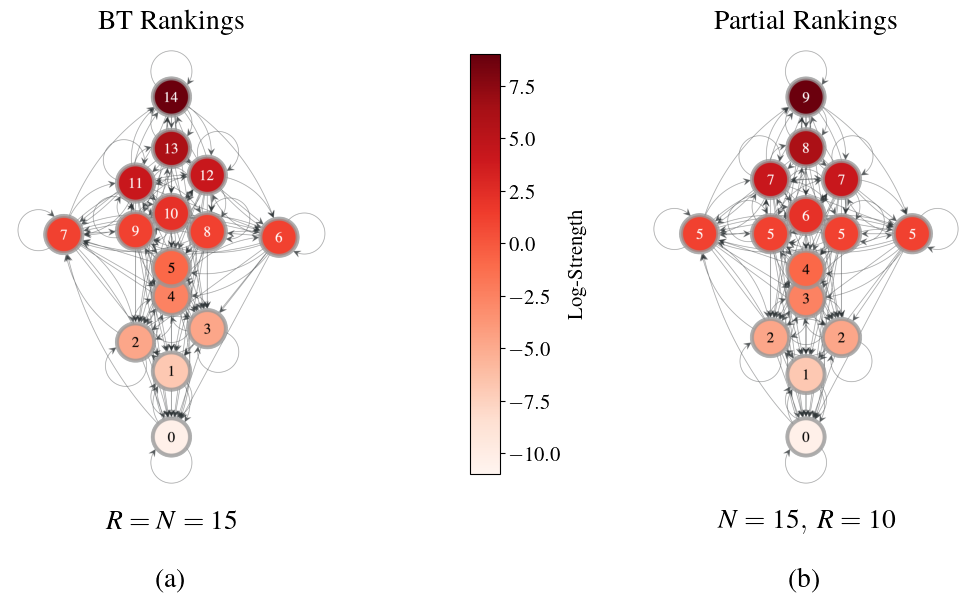

In [9]:
im_bt = mpimg.imread(output["bt"])
im_pr = mpimg.imread(output["pr"])

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].imshow(im_bt)
ax[0].axis('off')
ax[0].set_title("BT Rankings", fontsize=20)
ax[0].text(0.5, -0.05, r"$R = N = 15$", ha="center", va="center", fontsize=20, transform=ax[0].transAxes)
ax[0].text(0.5, -0.18, "(a)", ha="center", va="center", fontsize=20, transform=ax[0].transAxes)
ax[1].imshow(im_pr)
ax[1].axis('off')
ax[1].set_title("Partial Rankings", fontsize=20)
ax[1].text(0.5, -0.05, r"$N = 15,~R = 10$", ha="center", va="center", fontsize=20, transform=ax[1].transAxes)
ax[1].text(0.5, -0.18, "(b)", ha="center", va="center", fontsize=20, transform=ax[1].transAxes)

# Add colorbar
cbar_ax = fig.add_axes([0.5, 0.15, 0.02, 0.7])  # Position: [left, bottom, width, height]
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Reds), cax=cbar_ax)
cbar.set_label('Log-Strength', fontsize=15)
cbar.ax.tick_params(labelsize=15)

plt.show()